Let's check if solving OCPs the newly generated class for parametrized problems works (currently model interpolation only)

In [5]:
from parametrized_drone_MPC import ParametrizedDroneMPC
import sys
import os
import numpy as np

# Add parent directory of the notebook to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from drone_MPC import DroneMPCOptions

# Same Setup as in original class
l0 = 0.3
M = 2.0
m = 0.3
M_total = M + m
c = 1
g = 9.81
# Required total thrust for hovering T = (M_total)*g, and assuming symmetric rotors, each rotor speed is set to T/2 (with c=1)
w_val = (M_total * g) / (2.0*c)

# Create an instance of the MPC options (using the updated physical parameters)
opts = DroneMPCOptions(
    M=M,         # drone mass in kg
    m=m,         # load mass in kg (small compared to drone)
    Ixx=0.05,      # moment of inertia in kg·m²
    g=g,        # gravitational acceleration in m/s²
    c=c,         # rotor thrust constant
    L_rot=0.2,     # half distance between rotors in m
    k=500.0,       # stiff spring (N/m)
    l0=l0,        # spring rest length in m
    # Constraints and cost weighting matrices remain as defined by default

    N = 300,
    switch_stage = 300,
    step_sizes = [0.01]*300,

    w_min = -2*w_val,
    w_max = 2*w_val,
    w_dot_min = -30,
    w_dot_max = 30,
    phi_min = -np.pi*3/10,
    phi_max = np.pi*3/10,
    F_min = -2*w_val*c,
    F_max = 2*w_val*c,

    integrator_type="IRK",

    create_sim=False # Sim creation code not adapted for parametrized subclass
)

mpc_parametrized = ParametrizedDroneMPC(opts)

x0 = np.array([
    0.0,    # y position
    1.0,    # z position (hover altitude)
    0.0,    # phi (drone pitch)
    l0,     # r (pendulum length set to rest length)
    0.0,    # theta (pendulum angle)
    0.0,    # y_dot
    0.0,    # z_dot
    0.0,    # phi_dot
    0.0,    # r_dot
    0.0,    # theta_dot
    w_val,  # w1 (rotor speed)
    w_val   # w2 (rotor speed)
])
print("Initial hovering state:", x0)

# Define a reference position far away (for example, [10, 10])
pos_ref = np.array([10.0, 2.0])

# set initial guess to avoid division by zero for r
mpc_parametrized.set_initial_guess(x0, u_guess=np.zeros(2))

# Call the MPC solve function to compute the first control input
p = np.zeros(opts.N) # zero parameters 
p[10] = 0.05
u0 = mpc_parametrized.solve(x0, p, pos_ref)
print("First control input:", u0)


rm -f libacados_ocp_solver_drone_full_1743402635049.so
rm -f drone_full_1743402635049_cost/drone_full_1743402635049_cost_y_0_fun.o drone_full_1743402635049_cost/drone_full_1743402635049_cost_y_0_fun_jac_ut_xt.o drone_full_1743402635049_cost/drone_full_1743402635049_cost_y_0_hess.o drone_full_1743402635049_cost/drone_full_1743402635049_cost_y_fun.o drone_full_1743402635049_cost/drone_full_1743402635049_cost_y_fun_jac_ut_xt.o drone_full_1743402635049_cost/drone_full_1743402635049_cost_y_hess.o drone_full_1743402635049_cost/drone_full_1743402635049_cost_y_e_fun.o drone_full_1743402635049_cost/drone_full_1743402635049_cost_y_e_fun_jac_ut_xt.o drone_full_1743402635049_cost/drone_full_1743402635049_cost_y_e_hess.o acados_solver_drone_full_1743402635049.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

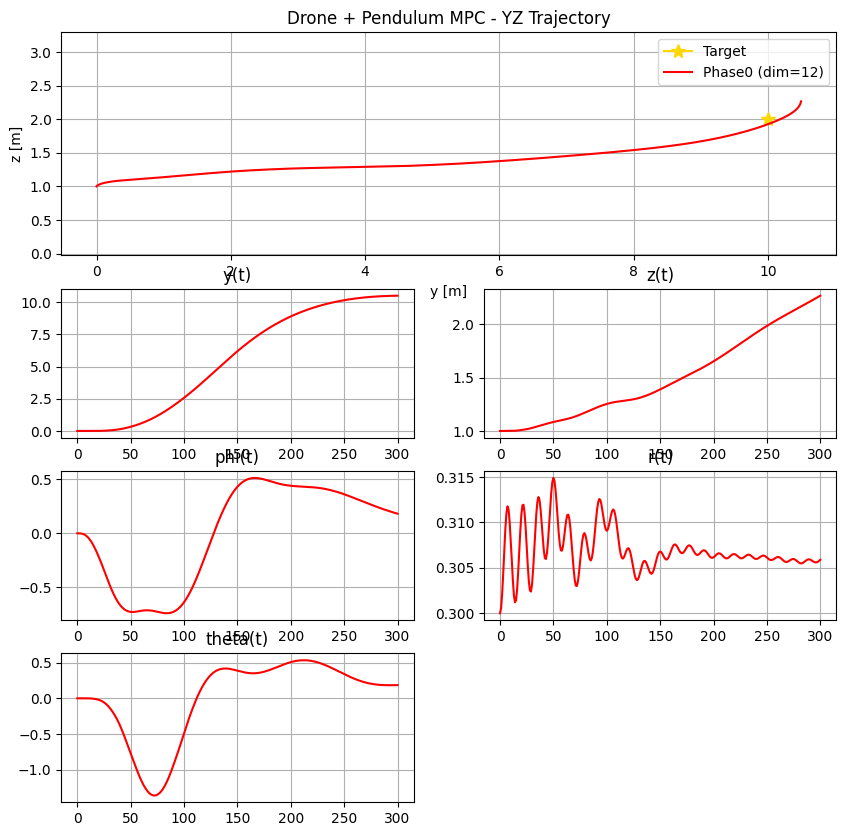

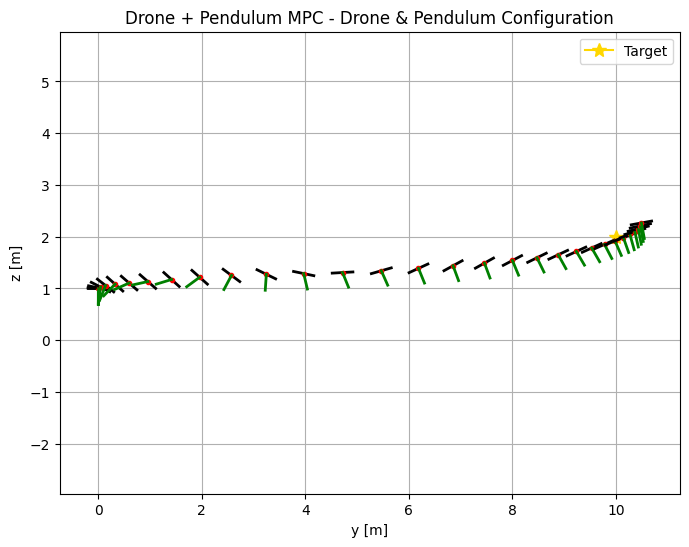

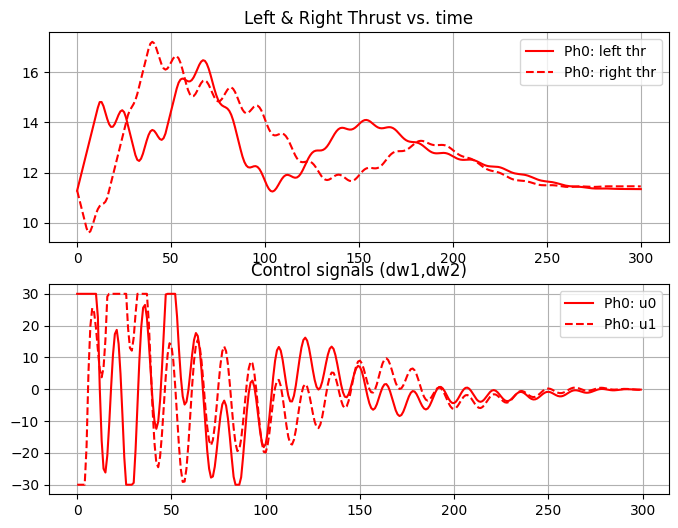

In [4]:
from plotting_utils_drone import plot_drone_mpc_solution

x_traj, u_traj = mpc_parametrized.get_planned_trajectory()

plot_drone_mpc_solution(
    mpc=mpc_parametrized, 
    reference_xy=pos_ref,
    open_loop_plan=x_traj,
    u_traj=u_traj,
    step_pose=10
)